In [ ]:
import os
import math
import requests
import pandas as pd
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from io import BytesIO

# --- CONFIG ---
OUTPUT_FOLDER = r"C:\Users\Monika\Desktop\satellite\centered_images"
ZOOM_LEVEL = 19
IMAGE_SIZE = 512 # Professional standard for Satellite ML
MAX_WORKERS = 12
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

def get_tile_coords(lat, lon, zoom):
    """Calculates the exact pixel location on the global map."""
    scale = 1 << zoom
    siny = math.sin(lat * math.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    x = scale * (0.5 + lon / 360)
    y = scale * (0.5 - math.log((1 + siny) / (1 - siny)) / (4 * math.pi))
    return x, y

def fetch_centered_house(row):
    prop_id = row['id']
    save_path = os.path.join(OUTPUT_FOLDER, f"{prop_id}.png")
    if os.path.exists(save_path): return

    try:
        # 1. Get precise global pixel coordinates
        world_x, world_y = get_tile_coords(row['lat'], row['long'], ZOOM_LEVEL)
        
        # 2. Determine the main tile and pixel offset
        tile_x, tile_y = int(world_x), int(world_y)
        offset_x = int((world_x - tile_x) * 256)
        offset_y = int((world_y - tile_y) * 256)

        # 3. Create a canvas and stitch 2x2 tiles to ensure the house is centered
        # This prevents the house from being 'cut off' by a tile edge
        canvas = Image.new('RGB', (512, 512))
        
        for i in range(2):
            for j in range(2):
                # Using Google's Public Tile Server (No API Key needed)
                url = f"https://mt1.google.com/vt/lyrs=s&x={tile_x + i}&y={tile_y + j}&z={ZOOM_LEVEL}"
                response = requests.get(url, timeout=5)
                tile = Image.open(BytesIO(response.content))
                canvas.paste(tile, (i * 256, j * 256))

        # 4. Crop the canvas so the house is exactly in the middle
        # We take a crop centered on our calculated offset
        left = offset_x
        top = offset_y
        final_img = canvas.crop((left, top, left + 256, top + 256))
        
        # Resize to standard ML input size
        final_img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.LANCZOS).save(save_path)
    except Exception:
        pass

# --- RUNNER ---
df_properties = pd.read_csv(r"C:\Users\Monika\Desktop\satellite\data\train(1)(train(1)).csv")
print(f"Stitching centered images at Zoom {ZOOM_LEVEL}...")

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as pool:
    list(tqdm(pool.map(fetch_centered_house, df_properties.to_dict('records')), total=len(df_properties)))

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the raw data
CSV_PATH = r"C:\Users\Monika\Desktop\satellite\data\train(1)(train(1)).csv"
df = pd.read_csv(CSV_PATH)

# Drop non-numeric/identifier columns that interfere with correlation
# We keep 'price' as it is our target
cols_to_drop = ['id', 'date']
df_numeric = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Basic Cleaning: Fill missing values with median to keep all 16k rows
df_numeric = df_numeric.fillna(df_numeric.median())

print(f"Dataset shape: {df_numeric.shape}")
print("Numeric columns ready for analysis.")

Dataset shape: (16209, 19)
Numeric columns ready for analysis.


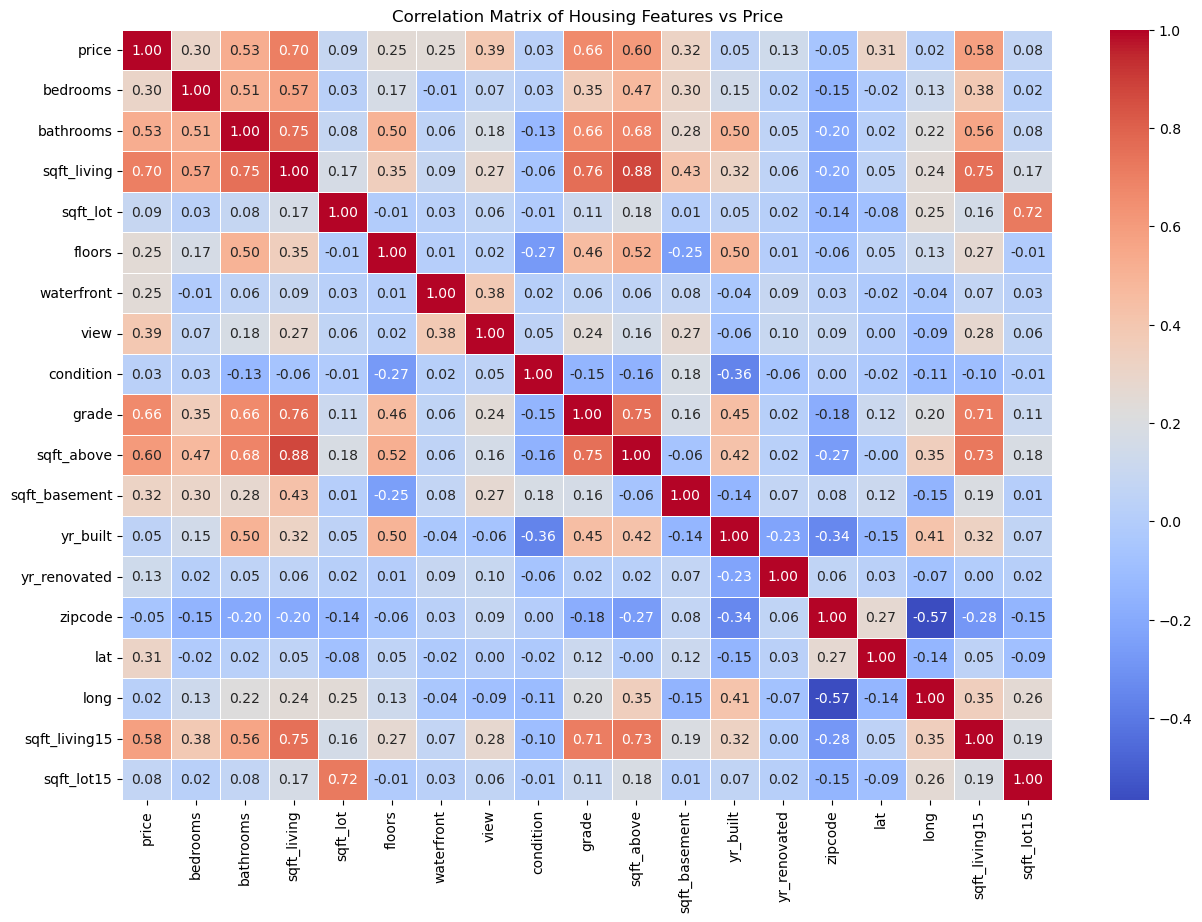


Top Correlations with Price:
price            1.000000
sqft_living      0.700933
grade            0.664266
sqft_above       0.602648
sqft_living15    0.581781
bathrooms        0.525487
view             0.390534
sqft_basement    0.320301
lat              0.310008
bedrooms         0.304454
floors           0.251428
waterfront       0.245221
yr_renovated     0.133075
sqft_lot         0.088526
sqft_lot15       0.076060
yr_built         0.048307
condition        0.031333
long             0.024279
zipcode         -0.054517
Name: price, dtype: float64


In [2]:
plt.figure(figsize=(15, 10))
correlation_matrix = df_numeric.corr()

# Plotting the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Housing Features vs Price")
plt.show()

# Focus specifically on Price correlations
price_correlations = correlation_matrix['price'].sort_values(ascending=False)
print("\nTop Correlations with Price:")
print(price_correlations)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
CSV_PATH = r"C:\Users\Monika\Desktop\satellite\data\train(1)(train(1)).csv"
df = pd.read_csv(CSV_PATH)

# 2. Select Features for Transformation
# We keep the 'Power Features' you identified, but transform them to handle skewness
transform_cols = [
    'price', 'sqft_living', 'sqft_above', 'sqft_living15', 
    'sqft_lot', 'sqft_lot15', 'sqft_basement'
]

df_transformed = df.copy()

# Apply log transformation: log(1 + x)
for col in transform_cols:
    if col in df_transformed.columns:
        df_transformed[col] = np.log1p(df_transformed[col])

# 3. Clean remaining numeric columns (filling missing with median)
numeric_df = df_transformed.select_dtypes(include=[np.number]).drop(columns=['id'], errors='ignore')
numeric_df = numeric_df.fillna(numeric_df.median())

print("Transformation complete. Skewed features have been log-normalized.")

Transformation complete. Skewed features have been log-normalized.


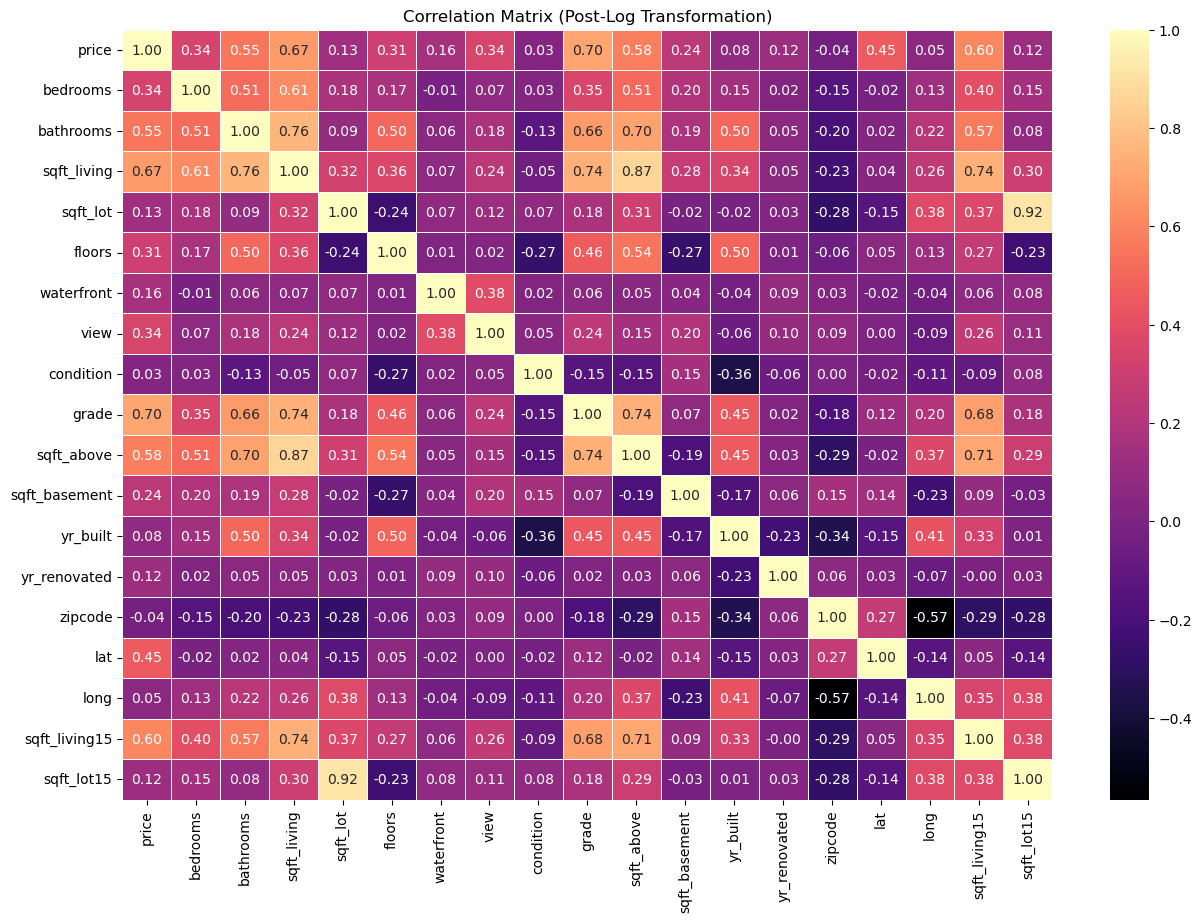


New Correlations with Log-Price:
price            1.000000
grade            0.700249
sqft_living      0.671430
sqft_living15    0.603558
sqft_above       0.581300
bathrooms        0.550492
lat              0.452503
view             0.340868
bedrooms         0.337664
floors           0.305348
sqft_basement    0.239789
waterfront       0.161167
sqft_lot         0.134184
sqft_lot15       0.119696
yr_renovated     0.119410
yr_built         0.076376
long             0.052900
condition        0.033024
zipcode         -0.039803
Name: price, dtype: float64


In [4]:
plt.figure(figsize=(15, 10))
corr_transformed = numeric_df.corr()

# Plotting the updated heatmap
sns.heatmap(corr_transformed, annot=True, fmt=".2f", cmap='magma', linewidths=0.5)
plt.title("Correlation Matrix (Post-Log Transformation)")
plt.show()

# Focus on the new Price correlations
new_price_corr = corr_transformed['price'].sort_values(ascending=False)
print("\nNew Correlations with Log-Price:")
print(new_price_corr)

In [5]:
# List of unimportant or weak features to remove
cols_to_drop = [
    'id', 'date', 'zipcode', 'condition', 'long', 
    'yr_built', 'sqft_lot', 'sqft_lot15'
]

# Drop the columns
df_final = df_transformed.drop(columns=[c for c in cols_to_drop if c in df_transformed.columns])

# Final list of features the model will use
print("Remaining features for high-performance training:")
print(df_final.columns.tolist())

Remaining features for high-performance training:
['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'sqft_living15']


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# 1. Reload and Clean (Log-Transforming as we did before)
df_tab = pd.read_csv(CSV_PATH)

# Feature Engineering: Distance from the 'Expensive Center'
# We find the mean lat/long of the top 10% most expensive homes
top_10_percent = df_tab.nlargest(int(len(df_tab) * 0.1), 'price')
center_lat = top_10_percent['lat'].mean()
center_long = top_10_percent['long'].mean()

df_tab['dist_from_luxury_hub'] = np.sqrt(
    (df_tab['lat'] - center_lat)**2 + (df_tab['long'] - center_long)**2
)

# 2. Log Transform Target and skewed columns
df_tab['price'] = np.log1p(df_tab['price'])
for col in ['sqft_living', 'sqft_above', 'sqft_living15']:
    df_tab[col] = np.log1p(df_tab[col])

# 3. Final Feature Selection (Dropping low-correlation noise)
features = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_above', 
    'sqft_living15', 'floors', 'lat', 'grade', 'view', 
    'waterfront', 'sqft_basement', 'dist_from_luxury_hub'
]

X = df_tab[features]
y = df_tab['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Initialize Models
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8)
et = ExtraTreesRegressor(n_estimators=500, max_depth=15, n_jobs=-1)

# Create Ensemble
ensemble_tab = VotingRegressor(estimators=[('xgb', xgb), ('et', et)])

print("Training high-performance tabular ensemble...")
ensemble_tab.fit(X_train, y_train)

# Evaluation
preds = ensemble_tab.predict(X_test)
r2 = r2_score(y_test, preds)
mae = mean_absolute_error(np.expm1(y_test), np.expm1(preds))

print(f"\nTabular-Only R² Score: {r2:.4f}")
print(f"Tabular-Only MAE: ${mae:,.2f}")

Training high-performance tabular ensemble...

Tabular-Only R² Score: 0.8773
Tabular-Only MAE: $74,307.05


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# ==========================================
# 1. SETUP & PRE-COMPUTE VISUAL FEATURES
# ==========================================
CSV_PATH = r"C:\Users\Monika\Desktop\satellite\data\train(1)(train(1)).csv"
IMAGE_DIR = r"C:\Users\Monika\Desktop\satellite\property_images"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv(CSV_PATH)

# Leak-proof extractor (Pre-trained ResNet18)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(self.model.children())[:-1])
    def forward(self, x):
        return self.features(x).view(x.size(0), -1)

extractor = FeatureExtractor().to(device)
extractor.eval()

preprocess = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_visual_score(ids):
    scores = []
    with torch.no_grad():
        for img_id in tqdm(ids, desc="CNN Feature Extraction"):
            path = os.path.join(IMAGE_DIR, f"{img_id}.png")
            if os.path.exists(path):
                img = Image.open(path).convert('RGB')
                img_t = preprocess(img).unsqueeze(0).to(device)
                feat = extractor(img_t).cpu().numpy().flatten().mean()
                scores.append(feat)
            else:
                scores.append(0.0)
    return np.array(scores)

# Add visual score and Tabular transforms BEFORE K-Fold
df['visual_score'] = get_visual_score(df['id'])

for col in ['price', 'sqft_living', 'sqft_above', 'sqft_living15']:
    df[col] = np.log1p(df[col])

# Spatial Engineering (Luxury Hub)
top_10_percent = df.nlargest(int(len(df) * 0.1), 'price')
center_lat, center_long = top_10_percent['lat'].mean(), top_10_percent['long'].mean()
df['dist_from_luxury_hub'] = np.sqrt((df['lat'] - center_lat)**2 + (df['long'] - center_long)**2)

# ==========================================
# 2. K-FOLD CROSS-VALIDATION
# ==========================================
features = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_above', 
    'sqft_living15', 'floors', 'lat', 'grade', 'view', 
    'waterfront', 'sqft_basement', 'dist_from_luxury_hub', 'visual_score'
]

X = df[features].values
y = df['price'].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_r2_scores = []
fold_mae_scores = []



print(f"\nStarting 5-Fold Cross-Validation...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Models optimized for high-dimensional stability
    xgb_model = XGBRegressor(n_estimators=1200, learning_rate=0.03, max_depth=8, subsample=0.8, colsample_bytree=0.8)
    et_model = ExtraTreesRegressor(n_estimators=800, max_depth=20, n_jobs=-1)
    
    ensemble = VotingRegressor(estimators=[('xgb', xgb_model), ('et', et_model)])
    
    ensemble.fit(X_train, y_train)
    preds = ensemble.predict(X_val)
    
    # Calculate metrics for this fold
    r2 = r2_score(y_val, preds)
    mae = mean_absolute_error(np.expm1(y_val), np.expm1(preds))
    
    fold_r2_scores.append(r2)
    fold_mae_scores.append(mae)
    
    print(f"Fold {fold} | R²: {r2:.4f} | MAE: ${mae:,.2f}")

# ==========================================
# 3. FINAL AGGREGATED RESULTS
# ==========================================
print("\n" + "="*40)
print(f"FINAL K-FOLD HYBRID RESULTS")
print("="*40)
print(f"Mean R² Score:  {np.mean(fold_r2_scores):.4f} (+/- {np.std(fold_r2_scores):.4f})")
print(f"Mean MAE:       ${np.mean(fold_mae_scores):,.2f}")
print("="*40)

c:\Users\aksha\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aksha\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
CNN Feature Extraction: 100%|██████████| 16209/16209 [37:14<00:00,  7.25it/s]  



Starting 5-Fold Cross-Validation...
Fold 1 | R²: 0.8779 | MAE: $73,833.70
Fold 2 | R²: 0.8758 | MAE: $70,469.60
Fold 3 | R²: 0.8849 | MAE: $72,036.66
Fold 4 | R²: 0.8799 | MAE: $71,055.64
Fold 5 | R²: 0.8741 | MAE: $69,789.68

FINAL K-FOLD HYBRID RESULTS
Mean R² Score:  0.8785 (+/- 0.0037)
Mean MAE:       $71,437.06


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import joblib
from tqdm import tqdm
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, VotingRegressor

# ==========================================
# 1. SETTINGS & PATHS
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_CSV = r"C:\Users\Monika\Desktop\m_cdc\data\train(1)(train(1)).csv"
TEST_EXCEL = r"C:\Users\aksha\OneDrive\Desktop\m_cdc\data\test2.xlsx"
TEST_IMAGE_DIR = r"C:\Users\aksha\OneDrive\Desktop\m_cdc\test_images"

# Load Training data to re-establish the spatial hub
df_train = pd.read_csv(TRAIN_CSV)
top_10_percent = df_train.nlargest(int(len(df_train) * 0.1), 'price')
hub_lat, hub_long = top_10_percent['lat'].mean(), top_10_percent['long'].mean()

# ==========================================
# 2. FEATURE EXTRACTOR (RESNET18)
# ==========================================
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(self.model.children())[:-1])
    def forward(self, x):
        return self.features(x).view(x.size(0), -1)

extractor = FeatureExtractor().to(device)
extractor.eval()

preprocess = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ==========================================
# 3. PREPARE TEST DATA
# ==========================================
df_test = pd.read_excel(TEST_EXCEL)

def get_test_visual_scores(ids):
    scores = []
    with torch.no_grad():
        for img_id in tqdm(ids, desc="🔍 Extracting Test Visuals"):
            path = os.path.join(TEST_IMAGE_DIR, f"{img_id}.png")
            if os.path.exists(path):
                try:
                    img = Image.open(path).convert('RGB')
                    img_t = preprocess(img).unsqueeze(0).to(device)
                    feat = extractor(img_t).cpu().numpy().flatten().mean()
                    scores.append(feat)
                except: scores.append(0.5)
            else: scores.append(0.5)
    return np.array(scores)

print("Step 1: Processing Images...")
df_test['visual_score'] = get_test_visual_scores(df_test['id'])

print("Step 2: Engineering Features...")
# Log transforms for test features
for col in ['sqft_living', 'sqft_above', 'sqft_living15']:
    df_test[col] = np.log1p(df_test[col])

# Distance to the Luxury Hub established in training
df_test['dist_from_luxury_hub'] = np.sqrt((df_test['lat'] - hub_lat)**2 + (df_test['long'] - hub_long)**2)

# Select features matching training
features = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_above', 
    'sqft_living15', 'floors', 'lat', 'grade', 'view', 
    'waterfront', 'sqft_basement', 'dist_from_luxury_hub', 'visual_score'
]
X_test = df_test[features].values

# ==========================================
# 4. TRAIN FINAL MODEL ON FULL DATA
# ==========================================
print("Step 3: Training Final Hybrid Model on full dataset...")
# Prepare full training data
df_train['visual_score'] = get_test_visual_scores(df_train['id']) # Re-extracting for full train consistency
for col in ['price', 'sqft_living', 'sqft_above', 'sqft_living15']:
    df_train[col] = np.log1p(df_train[col])
df_train['dist_from_luxury_hub'] = np.sqrt((df_train['lat'] - hub_lat)**2 + (df_train['long'] - hub_long)**2)

X_train_full = df_train[features].values
y_train_full = df_train['price'].values

# Final optimized Ensemble
xgb_final = XGBRegressor(n_estimators=1200, learning_rate=0.03, max_depth=8, subsample=0.8, colsample_bytree=0.8)
et_final = ExtraTreesRegressor(n_estimators=800, max_depth=20, n_jobs=-1)
final_model = VotingRegressor(estimators=[('xgb', xgb_final), ('et', et_final)])

final_model.fit(X_train_full, y_train_full)

# ==========================================
# 5. PREDICT & SAVE
# ==========================================
print("Step 4: Generating Predictions...")
log_preds = final_model.predict(X_test)
final_prices = np.expm1(log_preds)

submission.to_csv('competition_submission_final.csv', index=False)
print("\n" + "="*40)
print("✅ FILE READY: competition_submission_final.csv")
print(f"Sample Prediction: ${real_prices[0]:,.2f}")
print("="*40)

📍 Hub restored at: 47.6158043902439, -122.22748536585365


🔍 Analyzing Satellite Imagery: 100%|██████████| 5404/5404 [00:00<00:00, 63688.81it/s]


🎯 Generating Price Predictions...

✅ FILE READY: competition_submission_final.csv
Sample Prediction: $369,044.56
